# <span style="font-family: 'Computer Modern'; font-size: 42pt; font-weight: bold;">Quantum Convolutional Neural Network (QCNN): *Laboratory of Particle Physics and Cosmology (LPPC)*</span>

<style>
.small-break {
  margin-bottom: 5px; /* Adjust value to notebook needs */
  display: block;
}
</style>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Introduction:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">This instructional notebook introduces a new Quantum Convolutional Neural Network (QCNN) model and Python package, built using the PennyLane framework and trained via Amplitude Embedding of imported MNIST data. This notebook walkthrough aims to introduce convolutional neural networks using foundational quantum computing ideas and operations, whether you are a researcher, student, or just interested in practicing with the field of quantum computing.</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Background:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">The IceCube Neutrino Observatory generates a large daily data output, and while classical methods in machine learning have been effective, quantum computing offers the potential to analyze more data, avoiding bias by applying quantum entanglement operations to a given set of data and reducing this set to be trained only on its most relevant features. This QCNN model offers the possibility to work with the entirety of IceCube’s daily data output as a whole, without needing to resort to any data cuts.</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">TO-DO</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Contents:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">

1. **Installation and Setup**

**QCNN Package Dependencies:**
   - <code style="color: #FF8C00;">Matplotlib</code>: Visualization
   - <code style="color: #FF8C00;">Seaborn</code>: Enhanced visualizations
   - <code style="color: #FF8C00;">Pennylane</code>: Quantum computing
   - <code style="color: #FF8C00;">JAX</code>: High-performance numerical computing
   - <code style="color: #FF8C00;">Optax</code>: Optimization (used in <code style="color: #00CED1;">circuit_layers.py</code>)
   - <code style="color: #FF8C00;">NumPy</code>: Numerical operations
   - <code style="color: #FF8C00;">Pandas</code>: Data manipulation (used in <code style="color: #00CED1;">circuit_layers.py</code>)
   - <code style="color: #FF8C00;">Scikit-learn</code>: Dataset loading (used in <code style="color: #00CED1;">load_qc_data.py</code>)
   - <code style="color: #FF8C00;">Torch</code>: Data loading utilities (used in <code style="color: #00CED1;">load_qc_data.py</code>)

**Guidelines for Environment Setup:**
   - Configure <code style="color: #FF8C00;">JAX</code> for CPU execution and 64-bit precision:
   - jax.config.update('jax_platform_name', 'cpu')
   - jax.config.update("jax_enable_x64", True)
   <div class="small-break"></div>

2. **Package Files Description**
   - <code style="color: #FF8C00;">circuit_layers.py</code>: Quantum circuit and layers construction, as well as training-related functions. Contains sets of each class for two different QCNN models, denoted by "QC" vs. "LPPC". This notebook makes use of the QC implementation.
   - <code style="color: #FF8C00;">load_qc_data.py</code>: Functions for loading, preparing, and managing data to be passed to the QCNN. This notebook imports MNIST data from <code style="color: #00CED1;">sklearn</code> to train the model, and uses <code style="color: #00CED1;">jax.numpy</code> and JIT-compiled functions for greater optimization in both this file and <code style="color: #00CED1;">circuit_layers.py</code>.
   - <code style="color: #FF8C00;">qc_operators.py</code>: Functions for Gell-Mann matrices and relevant quantum operations.
   - <code style="color: #FF8C00;">setup.py</code>: Script for setting up the package.
   - <code style="color: #FF8C00;">__init__.py</code>: Initializes the package and its modules.
   - <code style="color: #FF8C00;">main.py</code>: Main entry point for running the application.
   <div class="small-break"></div>

3. **Basic Usage**
   - Importing the package
   - Creating and training a QCNN model
   <div class="small-break"></div>

4. **Visualization and Analysis**
   - Tools for visualizing QCNN performance
   - Analyzing results

</span>

## <span style="font-family: 'Computer Modern'; font-size: 26pt;">Sources:</span>
<span style="font-family: 'Computer Modern'; font-size: 12pt;">Much guidance and inspiration for this QCNN model was derived from an implementation presented in the following resource: <a href="https://github.com/Jaybsoni/Quantum-Convolutional-Neural-Networks/blob/main/qcnns_for_phase_recog/QCNNs%20for%20Classifying%20Quantum%20Phases%20of%20Matter.ipynb">QCNNs for Classifying Quantum Phases of Matter</a>.</span>

***


<span style="font-family: 'Computer Modern'; font-size: 14pt; font-weight: bold;">IMPORTS AND DEPENDENCIES:</span>

<span style="font-family: 'Computer Modern'; font-size: 12pt;">Relevant imports and dependencies for this QCNN construction include libraries for plotting and better visualization (Matplotlib and Seaborn), numerical computations with JIT compilation and differentiable programming (NumPy and JAX), and with specific stylistic selections applied for plotting aesthetics and configurations for JAX settings. Additionally, this QCNN relies on PennyLane for its framework for quantum computing operations.</span>

In [1]:
#### ***** IMPORTS / DEPENDENCIES *****:

### *** PLOTTING ***:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
sns.set()

### *** PENNYLANE ***:
import pennylane as qml
from pennylane import numpy as np

### *** JAX ***:
import jax;
## JAX CONFIGURATIONS:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

<hr style="border: none; border-top: 2px dashed currentColor;">

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">LOADING MNIST DATASET</span>

In [2]:
# ********************************************
#           INITIAL PARAMETER SETUP
# ********************************************

## RELEVANT CLASS IMPORTS:
from lppc_qcnn.load_qc_data import LoadDataQC

## *** DEFINE VARIABLES (QUBITS) ***:
# =======================================================
n_qubits = 6 # Number of qubits (six-qubit device)
active_qubits = list(range(n_qubits))  # Active qubits
num_wires = 6 # Number of wires
# =======================================================

## QUANTUM DEVICE:
# Select quantum device for QCNN (currently uses jax device for optimization):
device = qml.device('default.qubit.jax', wires=num_wires)
print(f"Selected device: {device.short_name}") # Confirm device selection

Selected device: default.qubit.jax


In [3]:
#### ***** RANDOM NUMBER GENERATOR *****:
seed = 0
rng_type = "jax" # Select rng for data processing (qcnn uses jax rng with 'PRNGKey')
# ------------------------------------------------------------------------------------
if rng_type == "jax":
    rng_jax = jax.random.PRNGKey(seed=seed) # Base (JAX)
    rng_jax_arr = jnp.array(rng_jax) # Base as array (JAX)
    print(f"RNG Package Type: {type(rng_jax)}") # Confirm JAX rng selection 
else:
    rng = np.random.default_rng(seed=seed) # Base (NP)
    print(f"RNG Package Type: {type(rng)}")  # Confirm NumPy rng selection
# ------------------------------------------------------------------------------------

RNG Package Type: <class 'jaxlib.xla_extension.ArrayImpl'>


In [4]:
# ********************************************
#          LOADING THE MNIST DATASET
# ********************************************

## *** DEFINE VARIABLES (DATA/IMAGES) ***:
# =======================================================
n_train_data = 2 # Number of TRAIN images for data
n_test_data = 2 # Number of TRAIN images for data
# =======================================================

# Prepare data by completing NumPy operators before casting with JAX:
features_np, labels_np = LoadDataQC.prepare_data()

# Convert to JAX arrays:
features = jnp.array(features_np)
labels = jnp.array(labels_np)

## JAX DATA CONFIGURATION:
# -------------------------------------------------------------------------------------------------
x_train, y_train, x_test, y_test = LoadDataQC.load_digits_data_jax(n_train=n_train_data,
                                            n_test=n_test_data, features=features, labels=labels)
# -------------------------------------------------------------------------------------------------

In [5]:
##                        ***** FUNCTIONALITY CHECK (DATA) *****
# -----------------------------------------------------------------------------------------
print(f"{'='*15} FUNCTIONALITY CHECK (DATA) {'='*15}")

# Shapes and Types:
print(f"\n{'='*14} (1) SHAPES AND TYPES {'='*14}")
print(f"• x_train type:  {type(x_train)}  | shape:  {x_train.shape}")
print(f"• y_train type:  {type(y_train)}  | shape:  {y_train.shape}")
print(f"• x_test type:  {type(x_test)}  | shape:  {x_test.shape}")
print(f"• y_test type:  {type(y_test)}  | shape:  {y_test.shape}")

# Normalization:
print(f"\n{'='*10} (2) NORMALIZATION {'='*10}")
print(f"• x_train first row norm:  {jnp.linalg.norm(x_train[0])}") # (JAX)
print(f"• x_test first row norm:  {jnp.linalg.norm(x_test[0])}") # (JAX)

# Label Uniqueness:
print(f"\n{'='*10} (3) LABEL UNIQUENESS {'='*10}")
print(f"• Unique labels -> y_train:  {jnp.unique(y_train, size=2, fill_value=1)}") # (JAX)
print(f"• Unique labels -> y_test:  {jnp.unique(y_test, size=2, fill_value=1)}") # (JAX)
# -----------------------------------------------------------------------------------------

=============== FUNCTIONALITY CHECK (DATA) ===============

============== (1) SHAPES AND TYPES ==============
• x_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)
• x_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)

========== (2) NORMALIZATION ==========
• x_train first row norm:  0.9999999999999999
• x_test first row norm:  0.9999999999999999

========== (3) LABEL UNIQUENESS ==========
• Unique labels -> y_train:  [0 1]
• Unique labels -> y_test:  [0 1]


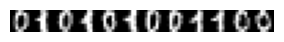

In [6]:
#### ***** DRAW MNIST DATA SUBSET IMAGE *****:
LoadDataQC.draw_mnist_data()

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CONSTRUCTING QUANTUM CIRCUIT</span>

In [7]:
# ********************************************
#    VISUALIZING / PLOTTING QUANTUM CIRCUIT
# ********************************************

## RELEVANT CLASS IMPORTS:
from lppc_qcnn.circuit_layers import LayersQC
layers_obj = LayersQC()

## DEFINE SAMPLE WEIGHTS / FEATURES FOR CONV_NET:
num_wires_draw = 6 # Number of wires (DRAWINGS)
weights = np.random.rand(81, 2) # <-- Shape ~ [(num_wires // 2) * (3 ** 3)]
last_layer_weights = np.random.rand(4 ** 2 - 1)
features = np.random.rand(2 ** num_wires_draw)

/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:581: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  bbox = text_obj.get_window_extent(renderer)


========================= QCNN QUANTUM CIRCUIT =========================


/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


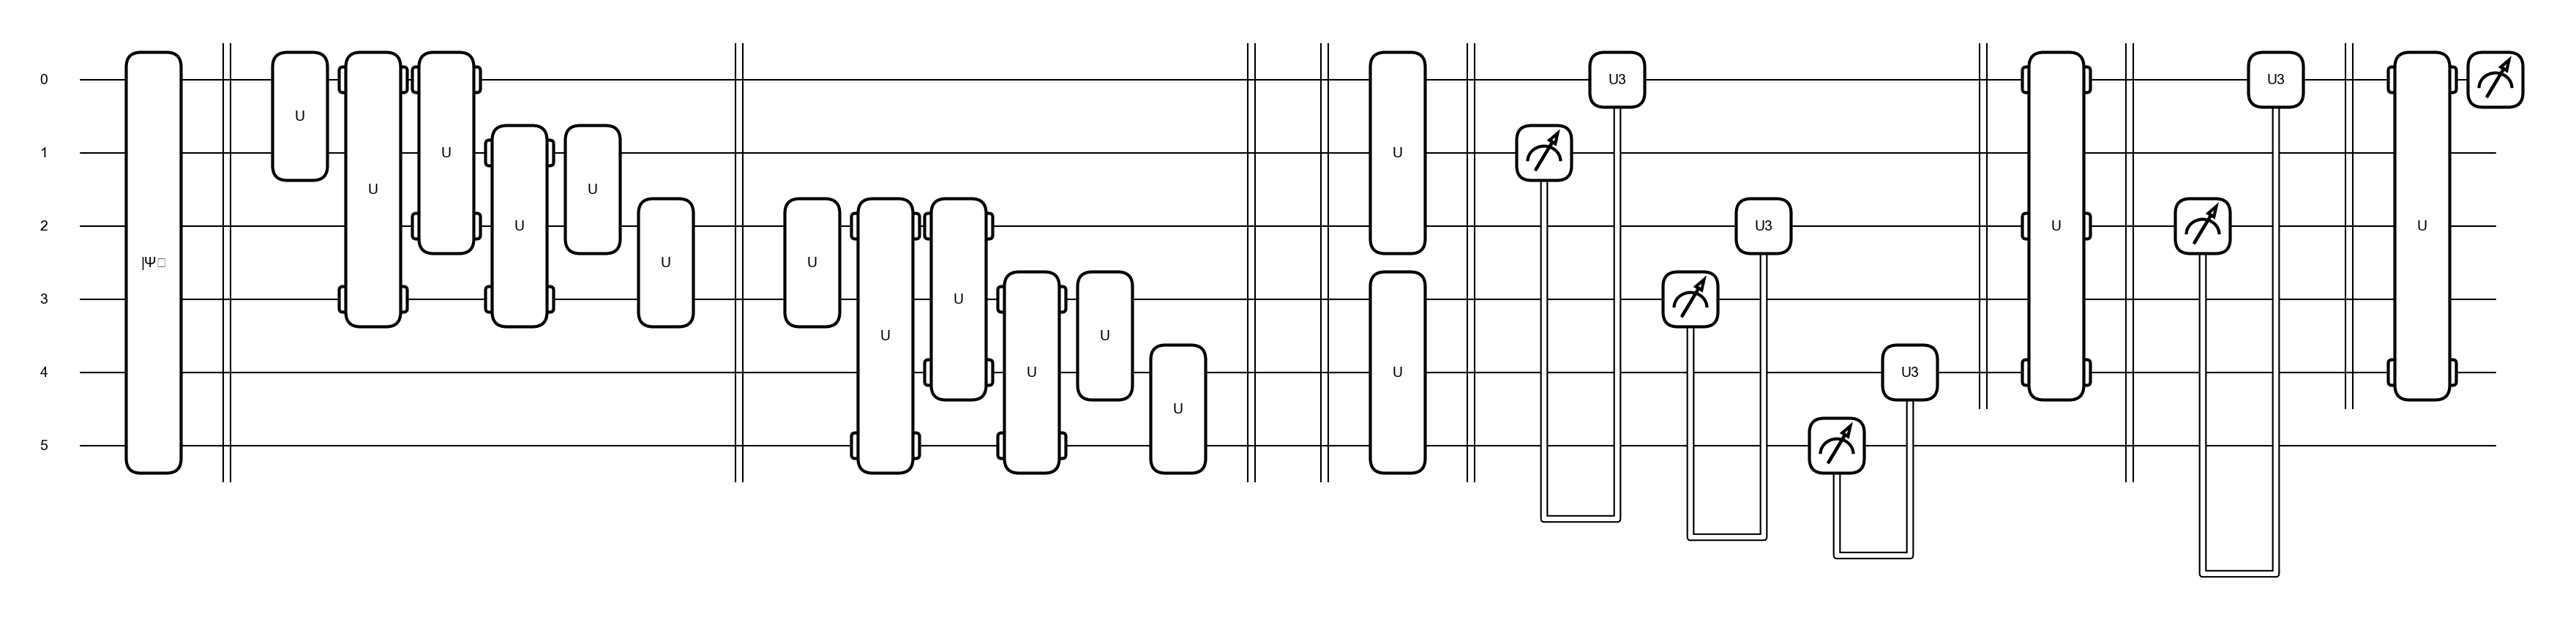

In [8]:
## DRAW QUANTUM CIRCUIT:
# Your code to draw the quantum circuit
fig, ax = qml.draw_mpl(layers_obj.conv_net)(
    layers_obj, weights, last_layer_weights, features
)

# Print constructed circuit:
print(f"{'='*25} QCNN QUANTUM CIRCUIT {'='*25}")
plt.show()

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">TRAINING MNIST DATA ON QUANTUM CIRCUIT</span>

In [11]:
# ********************************************
#           TRAINING QCNN / RESULTS
# ********************************************

## RELEVANT CLASS IMPORTS:
from lppc_qcnn.circuit_layers import TrainQC  # TrainQC() <--- STATIC METHOD (WITH JAX)

## *** DEFINE VARIABLES (TRAINING) ***:
# =======================================================
n_train = 5
n_test = 10
n_epochs = 100
n_reps = 10
# =======================================================

# TRAIN QCNN -> RESULTS:
results_df = TrainQC.compute_aggregated_results(n_train=n_train, n_test=n_test, n_epochs=n_epochs, n_reps=n_reps)

In [ ]:
##         ***** FUNCTIONALITY CHECK (TRAINING) *****
# -----------------------------------------------------------------------------------------
indices = list(range(99, 1000, 100)) # indices for every 100th step (starting from 0)
indices.insert(0, 0) # Add zero to beginning of list

# Use indices to filter DataFrame:
filtered_df = results_df.iloc[indices]
## PRINT:
print(f"\n{'='*31} QCNN RESULTS {'='*31}\n")
print(filtered_df)
# -----------------------------------------------------------------------------------------


=============================== QCNN RESULTS ===============================

    n_train step           train_cost train_acc            test_cost test_acc
0         5    1   0.4316107507972134       1.0  0.42788160843299905      0.8
99        5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
199       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
299       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
399       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
499       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
599       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
699       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
799       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
899       5  100  0.16125123532696112       1.0  0.21805947246269164      1.0
999       5  100  0.16125123532696112       1.0  0.218059472462

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">QCNN RESULTS</span>

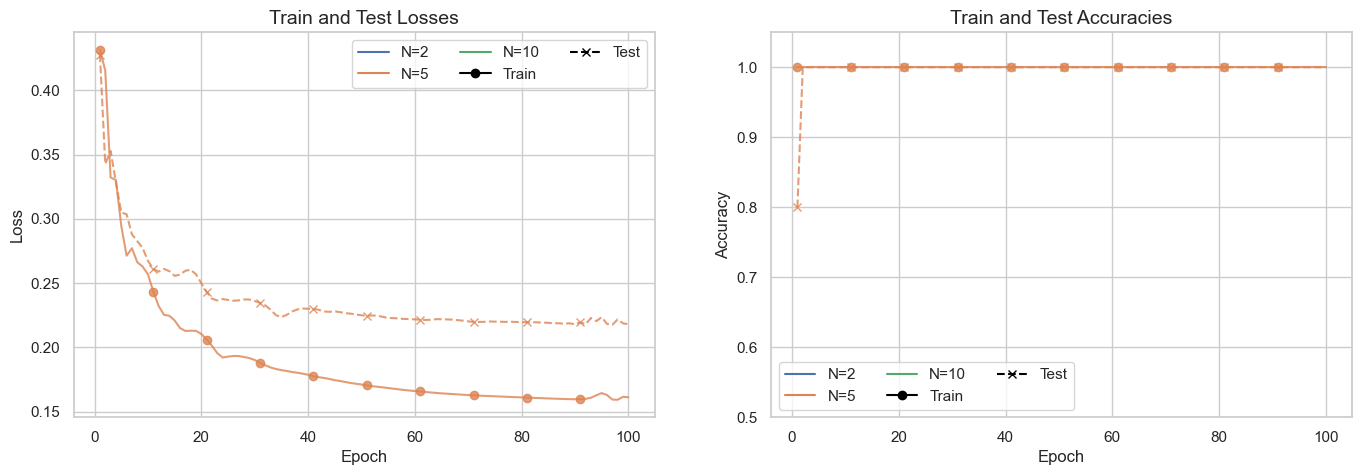

In [ ]:
# ********************************************
#     PLOTTING AGGREGATED TRAINING RESULTS
# ********************************************

# Plot aggregated training results:
TrainQC.plot_aggregated_results(results_df, n_train, steps=n_epochs, 
                                  title_loss='Train and Test Losses', 
                                  title_accuracy='Train and Test Accuracies', 
                                  markevery=10)

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">APPENDIX</span>

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 16pt;">Relevant QCNN Circuit Drawings:</span>

=============== QCNN CONVOLUTIONAL LAYER CIRCUIT ===============


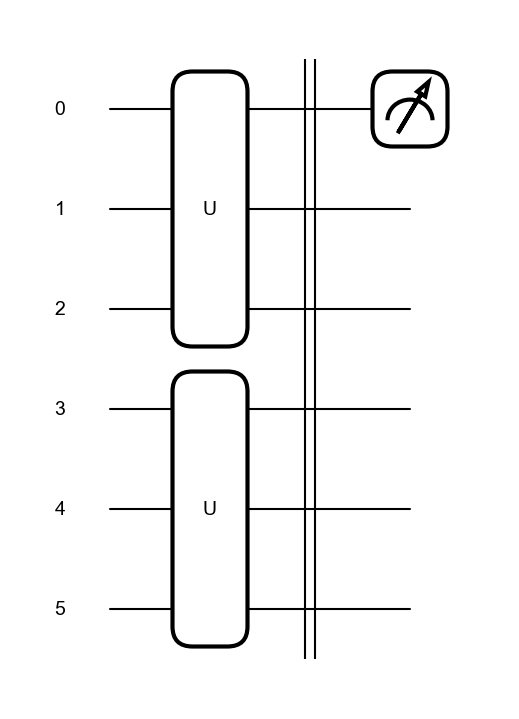

In [12]:
## DEFINE SAMPLE WEIGHTS / FEATURES FOR THREE_LAYER_CONV:
n_qubits_draw = 6  # Number of qubits
active_qubits_draw = list(range(n_qubits_draw))  # Active qubits
params_draw = weights[:, 0]  # (Note: Use appropriate slicing based on drawing needs)

## DRAW CONVOLUTIONAL LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.three_layer_conv_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print(f"{'='*15} QCNN CONVOLUTIONAL LAYER CIRCUIT {'='*15}")
plt.show()

========================= QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT =========================


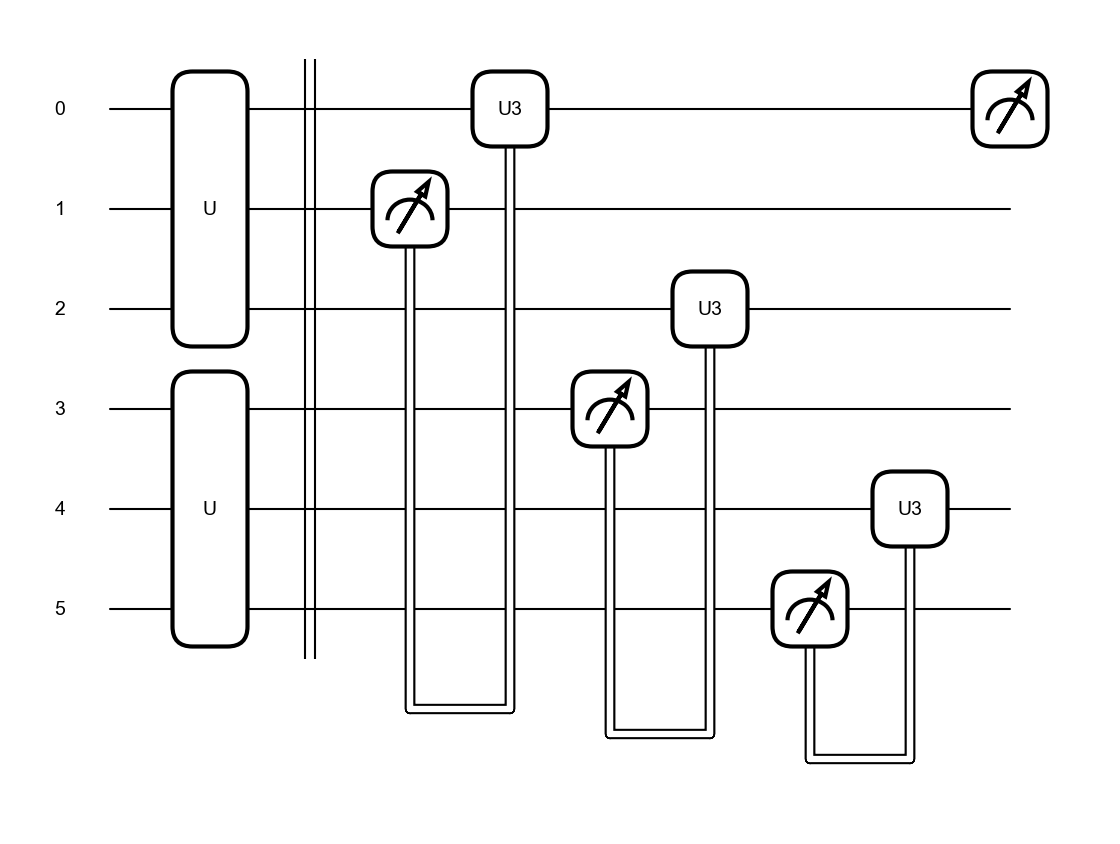

In [13]:
## DRAW CONVOLUTIONAL AND POOLING LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.conv_and_pooling_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print(f"{'='*25} QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT {'='*25}")
plt.show()